
### *Development Notebook*
# Extact flow across HEC-RAS Breaklines


In [1]:
import os, sys
sys.path.append(os.getcwd())
from ras_blines import *

In [2]:
ras_data_file =  r'C:\Data\Breaklines\P01.p01.hdf'
RasDomain = 'P01'

In [3]:
# Read data into rasPlan Object
rasPlan = rasHDF(ras_data_file, RasDomain)

# Read results data from unsteady computation block
fVel = rasPlan.unsteady_results(RasDomain, 'Face Velocity' )
wses = rasPlan.unsteady_results(RasDomain, 'Water Surface' )


C:\Users\Administrator\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [4]:
# Map coordinates of breakline vertices
fpoints_at_bline = rasPlan.fpoints_at_bline(rasPlan.FacePoints_Coordinate)

# Save face points to a geodataframe (to optimize searching)
fpointsGdf = fpoints_gdf(rasPlan.FacePoints_Coordinate)
# fpointsGdf.head(3)

In [5]:
# Buffer points to identify breakline points intersecting facepoints
buffered_fpoints_gdf =  buffer_fpoints(rasPlan.FacePoints_Coordinate)


In [6]:
# Filter points to compute flow at valid break lines only
valid_lines, error_lines = rasPlan.bline_filter(fpoints_at_bline)
valid_lines

58 4
69 3
17 2
54 2
46 2
38 0
81 3
8 1
6 2
8 1
4 2
2 0
2 2
9 0
3 1
9 2
9 2
4 2
18 2
7 2
11 2
10 1
11 2
13 2
7 1
3 2
6 1
2 2
3 1
6 1
6 1
3 0
26 2
4 1
57 2
11 2
5 2
4 0
2 1
10 2
10 2
7 2
56 3


['Breakline 14', 'Breakline 29']

In [7]:
error_lines

['Breakline 1',
 'Breakline 2',
 'Breakline 3',
 'Breakline 5',
 'Breakline 6',
 'Breakline 7',
 'Breakline 8',
 'Breakline 9',
 'Breakline 10',
 'Breakline 11',
 'Breakline 12',
 'Breakline 13',
 'Breakline 15',
 'Breakline 16',
 'Breakline 17',
 'Breakline 18',
 'Breakline 19',
 'Breakline 20',
 'Breakline 21',
 'Breakline 22',
 'Breakline 23',
 'Breakline 24',
 'Breakline 25',
 'Breakline 26',
 'Breakline 27',
 'Breakline 28',
 'Breakline 30',
 'Breakline 31',
 'Breakline 32',
 'Breakline 33',
 'Breakline 34',
 'Breakline 35',
 'Breakline 36',
 'Breakline 37',
 'Breakline 38',
 'Breakline 39',
 'Breakline 40',
 'Breakline 41',
 'Breakline 42',
 'Breakline 43',
 'Breakline 4']


                                                 geometry
108595  POLYGON ((200339.164480595 1691088.15237225, 2...
108596  POLYGON ((200337.8897301831 1690988.329609224,...
108597  POLYGON ((200336.6149797711 1690888.506846197,...
108598  POLYGON ((200335.3402293592 1690788.684083171,...
108599  POLYGON ((200334.0654789473 1690688.861320144,...
108600  POLYGON ((200332.7907285353 1690589.038557118,...
108601  POLYGON ((200331.5159781234 1690489.215794092,...
108602  POLYGON ((200330.2412277115 1690389.393031065,...
108603  POLYGON ((200328.9664772995 1690289.570268039,...
108604  POLYGON ((200327.6917268876 1690189.747505013,...
108605  POLYGON ((200326.4169764757 1690089.924741986,...
108606  POLYGON ((200325.1422260637 1689990.10197896, ...
108607  POLYGON ((200323.8674756518 1689890.279215934,...
108608  POLYGON ((200322.5927252399 1689790.456452907,...
108609  POLYGON ((200321.3179748279 1689690.633689881,...
108610  POLYGON ((200320.043224416 1689590.810926854, ...
108611  POLYG

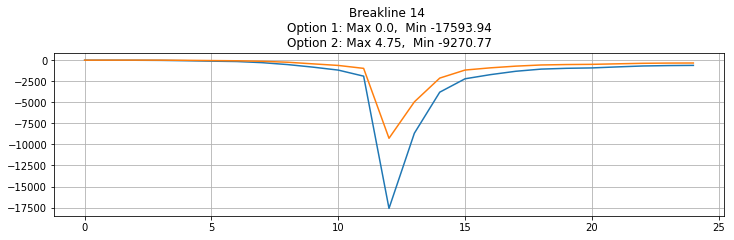

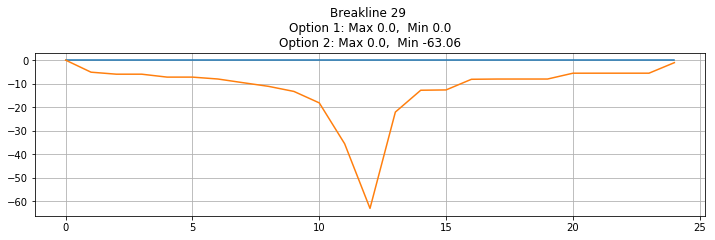

In [8]:
# Iterate over breaklines & Compute flow
for bLine  in valid_lines:
    
    # Create line object with point vertices
    start_point, fpointsOnLineGDF = get_bline_fpoint_pairs(bLine, rasPlan.blineCoords, buffered_fpoints_gdf)
    print(fpointsOnLineGDF)
    # Using the line, sort the points to identify ordering
    sortedPoints =ordered_points(fpointsOnLineGDF, fpointsGdf, start_point)
    
    # ?
    sortedPointList = list(sortedPoints.keys())
    pointCombos = get_point_combos(sortedPointList)

    try:
        # Builds components needed for relationship tables
        cells, faceCellCombos, faceNormal = build_geometry(pointCombos,
                                                           rasPlan.Faces_FacePoint_Indexes,
                                                           rasPlan.Cells_Minimum_Elevation,
                                                           rasPlan.FacePoints_Face_and_Orientation_Info,
                                                           rasPlan.FacePoints_Face_and_Orientation_Values,
                                                           rasPlan.Faces_Cell_Indexes)
        
        # Identify cell pairs that face each other
        crossCellPairs, infoTable = get_crossCelll_pairs(rasPlan.Cells_Face_and_Orientation_Info, faceCellCombos, cells)
        
        # ?
        checkCells = get_checkCells(infoTable, rasPlan.Cells_Face_and_Orientation_Values)

        # ?
        sharedPairs = get_sharedPairs(checkCells, crossCellPairs)

        # Group continuous cells on either side of the breakline
        Group1, Group2 = get_groups(sharedPairs)

        # Temporarily check both datasets. TODO: Find method to identify appropriate group
        m1 = map_cellFaces(faceCellCombos, Group1)
        m2 = map_cellFaces(faceCellCombos, Group2)
        cellmaps = [m1, m2]
        cellmap_results=[]
        
        # Calculate Flow at breakline
        for cellFaceMap in cellmaps:
            cellIDs = list(cellFaceMap.keys())
            faceIDs = list(cellFaceMap.values())
            
            # Read in results data at cell/face pairs along the breakline
            wse_slice = wses[:, cellIDs]
            fVel_slice = fVel[:, faceIDs]
            
            # Map Cell faces to Area/Elevation data 
            table_map = mapTable(faceIDs, rasPlan.Faces_Area_Elevation_Info)
            
            # Map face-normal velocity directions
            faceVectors = rasPlan.Faces_NormalUnitVector_and_Length[faceIDs,2]
            
            # Extend Area/Elevation curves
            areaElevCurves = extrapElevAreas(table_map, rasPlan.Faces_Area_Elevation_Values, rasPlan.Faces_NormalUnitVector_and_Length)
            
            # Compute combined Flow along breakline
            q = compute_blineFlow(bLine, wses, cellIDs, cellFaceMap, areaElevCurves, fVel, faceNormal)
            
            # Temporary: make a list of flow calcuated in both directions until a method for determining 
            # auto-identify which set is written
            cellmap_results.append(q)
            
        # Plot for now....need to eventually write to file & save plots
        doublePlot(bLine, cellmap_results[0], cellmap_results[1]);

    except IndexError as e:
        print('Error on {}, {}'.format(bLine, e))

#### TODO: 
 1. Auto-identify flow direction 
 - Write output to json
 - Create file (notebook?) engineers can use for QAQC

# End